# Lab 2. Data Analytics Using PySpark
## Scalable and Distributed Computing
Sara Dovalo del Río, Alejandra Estrada Sanz and Luis Ángel Rodríguez García

### Part I

The aim of this assignment's part is to carry out the studies we have considered necessary on the data provided by the (NYC Government)[https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page]. This dataset is about the taxi trips in this city recorded by the yellow cabs and the green ones (only allowed to operate in outer boroughs except Manhattan and the main airports). 

These are the variables which are presented in the dataset:

- _VendorID_: a code indicating an id of the provider that generated the record
- _tpep\_pickup_datetime_: date and time when the meter was engaged
- _tpep\_dropoff_datetime_:  date and time when the meter was disengaged
- _passenger_count_: number of passengers in the vehicle (this is a value defined by the driver)
- _trip\_distance_: elapsed trip distance in miles reported by the taximeter
- _rateCodeID_: final rate code (1=_Standard rate_, 2=_JFK_, 3=_Newark_, 4=_Nassau or Westchester_, 5=_Negotiated fare_ and 6=_Group ride_)
- _store\_and\_fwd\_flag_: a flag which indicates if the trip was recorded in the car before sending to the server due to bad connection in that moment (_Y_ (store and forward) or _N_)
- _PULocationID_: taxi Zone in which the taximeter was engaged
- _DOLocationID_: taxi Zone in which the taximeter was disengaged
- _payment\_type_: numeric code signifying how the passenger paid for the trip (1=_Credit card_, 2=_Cash_, 3=_No charge_, 4=_Dispute_, 5=_Unknown_ and 6=_Voided trip_)
- _fare\_amount_: time-and-distance fare calculated by the meter
- _extra_: miscellaneous extras and surcharges
- _mta\_tax_: $0.50 MTA tax that is automatically triggered based on the metered rate in use
- _tip\_amount_: field is automatically populated for credit card tips (cash tips are not included)
- _tolls\_amount_: total amount of all tolls paid in trip. 
- _improvement\_surcharge_: $0.30 improvement surcharge assessed trips at the flag drop
- _total\_amount_: total amount charged to passengers (does not include cash tips)

First of all, we are loading the required python modules and later on we are going to read the two csv files and concatenate each of them.

In [70]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
import numpy as np

We are going to create two functions that returns the payment type based on the id and the fare rate apply base on the code id.

In [3]:
def get_payment_type(payment_id):
    if(payment_id == 1):
        return "credit card"
    elif(payment_id == 2):
        return "cash"
    elif(payment_id == 3):
        return "no charge"
    elif(payment_id == 4):
        return "dispute"
    elif(payment_id == 5):
        return "unknown"
    else:
        return "voided trip"

def get_rate_code_id(rate_code_id):
    if(rate_code_id == 1):
        return "standard rate"
    elif(rate_code_id == 2):
        return "JFK airport"
    elif(rate_code_id == 3):
        return "newark airport"
    elif(rate_code_id == 4):
        return "nassau or westchester county"
    elif(rate_code_id == 5):
        return "negotiated fare"
    else:
        return "group ride"

In [93]:
data_1 = pd.read_csv("data/tripdata_2017-01.csv")
data_2 = pd.read_csv("data/tripdata_2017-02.csv")
df = pd.concat([data_1, data_2], axis=0, ignore_index=True)
(n, p) = df.shape
df.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

Nex steps is about to give the proper data type to specific columns:

- _tpep\_pickup\_datetime_ and _tpep\_dropoff\_datetime_ to data time data type
- _store\_and\_fwd\_flag_ is a binary variable
- _payment\_type_ is an unordered categorical variable
- _RatecodeID_ is an unordered categorical variable

In [94]:
store_and_fwd_flag_mapper = {'Y': True, 'N': False}
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map(store_and_fwd_flag_mapper)
df['RatecodeID'] = pd.Categorical(df['RatecodeID'])
df['payment_type'] = pd.Categorical(df['payment_type'])
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df.describe()

,VendorID,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,1.942420e+06,1.942420e+06,1.942420e+06,1.942420e+06,1.942420e+06,1.942420e+06,1.942420e+06,1.942420e+06,1.942420e+06,1.942420e+06,1.942420e+06,1.942420e+06
mean,1.549626e+00,1.636325e+00,2.858966e+00,1.631381e+02,1.609275e+02,1.271443e+01,2.963525e-01,4.974638e-01,1.761130e+00,2.821524e-01,2.996505e-01,1.585489e+01
std,4.975313e-01,1.273392e+00,3.604305e+00,6.700308e+01,7.084773e+01,4.058548e+02,4.086390e-01,6.383494e-02,2.515181e+00,1.859337e+00,1.395725e-02,4.059285e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-1.200000e+02,-5.350000e+01,-5.000000e-01,-1.167000e+01,-1.050000e+01,-3.000000e-01,-1.203000e+02
25%,1.000000e+00,1.000000e+00,9.800000e-01,1.140000e+02,1.070000e+02,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.300000e+00
50%,2.000000e+00,1.000000e+00,1.610000e+00,1.620000e+02,1.620000e+02,9.000000e+00,0.000000e+00,5.000000e-01,1.320000e+00,0.000000e+00,3.000000e-01,1.130000e+01
75%,2.000000e+00,2.000000e+00,3.000000e+00,2.330000e+02,2.330000e+02,1.400000e+01,5.000000e-01,5.000000e-01,2.320000e+00,0.000000e+00,3.000000e-01,1.680000e+01
max,2.000000e+00,9.000000e+00,1.517000e+02,2.650000e+02,2.650000e+02,5.385792e+05,5.554000e+01,5.480000e+01,3.660000e+02,9.055400e+02,3.000000e-01,5.385800e+05


We are going to check if there are missing values and assess their linear relationship between each other using a plotting heatmap. 

In [58]:
print('Are there any missin value: {}'.format((df.isna().sum().sort_values() > 0).any()))

Are there any missin value: False


Although we don't have any missing value, we are going to assure that the values associated to some variables are greater or equal than zero, if they are not, we are going to substitute this value by the mean of this variable.

In [103]:
df.loc[df['fare_amount'] < 0, 'fare_amount'] = np.mean(df['fare_amount'] >= 0)
df['fare_amount'] = pd.to_numeric(df['fare_amount'])
df.loc[df['extra'] < 0, 'extra'] = np.mean(df['extra'] >= 0)
df.loc[df['mta_tax'] < 0, 'mta_tax'] = np.mean(df['mta_tax'] >= 0)
df.loc[df['tip_amount'] < 0, 'tip_amount'] = np.mean(df['tip_amount'] >= 0)
df.loc[df['tolls_amount'] < 0, 'tolls_amount'] = np.mean(df['tolls_amount'] >= 0)
df.loc[df['improvement_surcharge'] < 0, 'improvement_surcharge'] = np.mean(df['improvement_surcharge'] >= 0)
df.loc[df['total_amount'] < 0, 'total_amount'] = np.mean(df['total_amount'] >= 0)

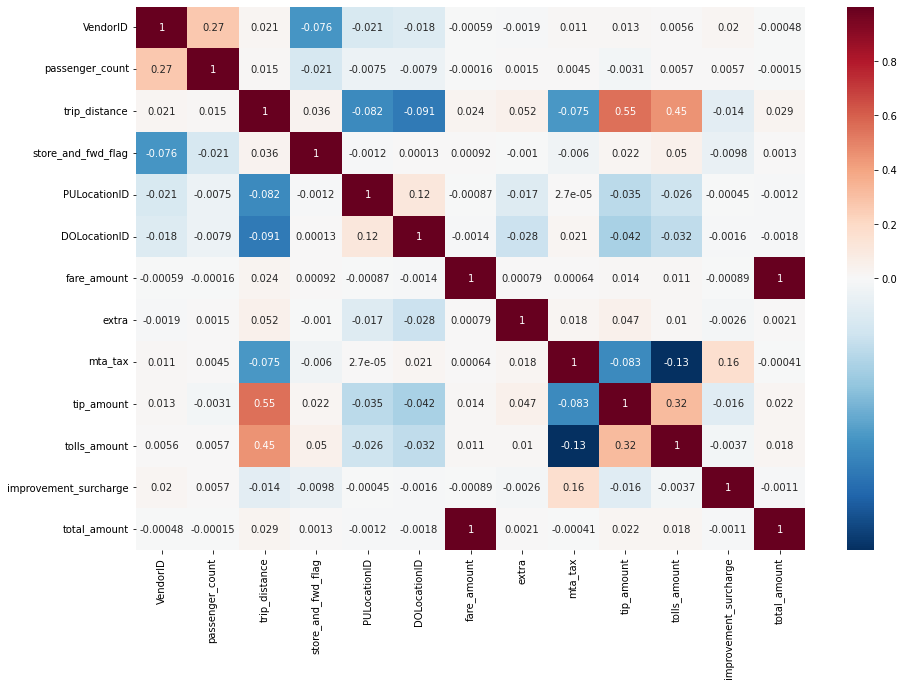

In [96]:
correlation=df.corr()
plt.figure(figsize = (15,10))
sns.heatmap(correlation, annot = True, cmap="RdBu_r", norm=TwoSlopeNorm(0), vmin = -1, vmax = 1)
plt.show()

As we can see above, there are linear relationship between the following pairs of variables:

- There is a perfect positive linear correlation between _fare\_amount_ and _total\_amount_
- There is a positive correlation (0.55) between _trip\_distance_ and _tip\_amount_
- There is a positive correlation (0.45) between _trip\_distance_ and _tolls\_amount_
- There is a positive correlation (0.33) between _mta\_tax_ and _improvement\_surcharge_
- There is a positive correlation (0.32) between _tip\_amount_ and _tolls\_amount_


Let's plot the density plots associated to these quantitative variables:

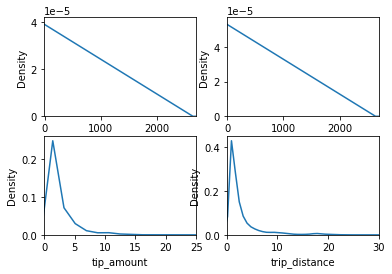

In [105]:
fig, axs = plt.subplots(2, 2)
total_amount_plot = sns.kdeplot(data=df, x="total_amount", ax=axs[0,0])
fare_amount_plot = sns.kdeplot(data=df, x="fare_amount", ax=axs[0,1])
tip_amount_plot = sns.kdeplot(data=df, x="tip_amount", ax=axs[1,0])
trip_distance_plot = sns.kdeplot(data=df, x="trip_distance", ax=axs[1,1])
axs[0,0].set_xlim(-10,2700)
axs[0,1].set_xlim(-10,2700)
axs[1,0].set_xlim(0,25)
axs[1,1].set_xlim(0,30)
plt.show()

In the plots above, we can see that the distribution of the _tip\_amount_ and the _trip\_distance_ are right skewed, having concentrated their values to the left (approximately, between 0 and 10). Moreover, as we said before in the correlation plot, it looks like the _total\_amount_ and the _fare\_amount_ are the same variables. Then, we are going to proceed to delete one of them, in this case the chosen variables is _fare\_amount_. Then, the total amount (in dolars) of the trip is between 0 euros and, approximately, 2700.
Now, we want to know more information about the journey data, what's the payment method used on the longest trip in average?

In [106]:
df = df.drop('fare_amount', axis=1)

t1 = df['tpep_dropoff_datetime'].min()
t2 = df['tpep_dropoff_datetime'].max()
print('Dates from {} to {}'.format(t1, t2))

df_group = df.groupby('payment_type')
payment_highest_distance = int(df_group.mean('trip_distance')['trip_distance'].idxmax())
print('The payment with the highest average distance is {}'.format(get_payment_type(payment_highest_distance)))

Dates from 2017-01-01 00:00:00 to 2017-02-24 22:04:42
The payment with the highest average distance is credit card


Average distance depending on the part of the day

In [28]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['pu_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pu_day'] = df['tpep_pickup_datetime'].dt.dayofyear
df['pu_wday'] = df['tpep_pickup_datetime'].dt.dayofweek
df['pu_month'] = df['tpep_pickup_datetime'].dt.month

morning = df[(df['pu_hour'] >= 7) & (df['pu_hour'] < 12)]
afternoon = df[(df['pu_hour'] >= 12) & (df['pu_hour'] < 16)]
evening = df[(df['pu_hour'] >= 16) & (df['pu_hour'] < 18)]
night = df[(df['pu_hour'] >= 18) & (df['pu_hour'] <= 23)]
latenight =df[(df['pu_hour'] >=0 ) & (df['pu_hour'] < 7)]

print("During mornings (from 7am to 9 am), the average distance is {:0.2f} miles".format(morning.trip_distance.mean()))
print("During afternoon (from 12m and 4pm), the average distance is {:0.2f} miles".format(afternoon.trip_distance.mean()))
print("During evening (from 4pm to 6pm), the average distance is {:0.2f} miles".format(evening.trip_distance.mean()))
print("During nights (from 6pm to 12pm), the average distance is {:0.2f} miles".format(night.trip_distance.mean()))
print("During late nights (from 12pm to 7 am), the average distance {:0.2f} miles".format(latenight.trip_distance.mean()))

During mornings (from 7am to 9 am), the average distance is 2.53 miles
During afternoon (from 12m and 4pm), the average distance is 2.80 miles
During evening (from 4pm to 6pm), the average distance is 2.84 miles
During nights (from 6pm to 12pm), the average distance is 2.88 miles
During late nights (from 12pm to 7 am), the average distance 3.34 miles


We can see that the distances are greater at night, this may be due to that in many cities there is no public transport at this time, therefore people choose to travel by taxi. Latenight trip has an effect on distance.

Frequency of passenger numbers

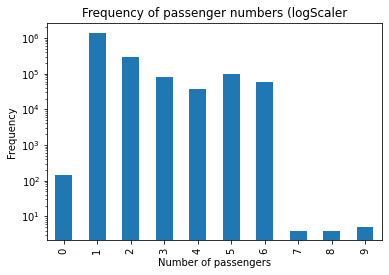

In [29]:

passengers = df['passenger_count'].value_counts().sort_index()
passengers.plot(kind = 'bar',logy = True)
plt.xlabel('Number of passengers')
plt.ylabel('Frequency')
plt.title('Frequency of passenger numbers (logScaler')
plt.show()

Trip distance depending on the number of passengers

Text(0.5, 1.0, 'Trip distance depending on the number of passengers')

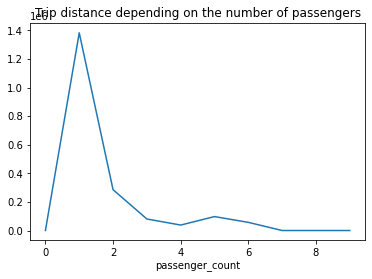

In [31]:
passenger_vs_distance = df.groupby('passenger_count').count()['trip_distance']
passenger_vs_distance.plot()
plt.title('Trip distance depending on the number of passengers')

There is no correlation between group size and distance